In [70]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix

In [118]:
def RRMSE(noisy_data: np.ndarray, noiseless_data: np.ndarray) -> float:
    """
    Computes the Relative Root Mean Squared Error (RRMSE) between the noisy and noiseless data.
    """

    return np.sqrt(np.sum(np.square((noisy_data - noiseless_data)))) / np.sqrt(np.sum(np.square(noiseless_data)))


In [23]:
data = np.array(h5py.File('data/assignmentMathImagingRecon_chestCT.mat')['imageAC'], dtype=np.float32)
print(data.shape)

(512, 512)


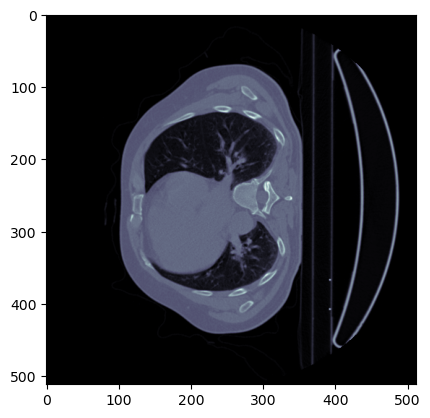

In [24]:
plt.imshow(data, cmap='bone')

In [38]:
def myXrayIntegration(interp, t, theta, ds):

    sum = 0
    for s in np.arange(-128, 128, ds):
        x = t * np.cos(theta) - s * np.sin(theta)
        y = t * np.sin(theta) + s * np.cos(theta)
        sum += interp(x+256, y+256) * ds
    return sum


In [47]:
def myXrayCTRadonTransform(phantom_img, d_theta = 1, dt=4, ds = 2):

    x_range, y_range = phantom_img.shape

    x = np.linspace(0, x_range, x_range, endpoint=False)
    y = np.linspace(0, y_range, y_range, endpoint=False)

    interp = RectBivariateSpline(x, y, phantom_img)

    max_radius = 360
    d_theta = np.deg2rad(d_theta)

    angles = np.arange(0, np.pi, d_theta)
    dist = np.arange(-max_radius, max_radius, dt)
    radon_transform = np.zeros((len(dist), len(angles)))

    for i, theta in enumerate(angles):
        for j, t in enumerate(dist):
            radon_transform[j, i] = myXrayIntegration(interp, t, theta, ds)

    plt.imshow(radon_transform, cmap='autumn')
    return radon_transform

/tmp/ipykernel_8155/1512589573.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  radon_transform[j, i] = myXrayIntegration(interp, t, theta, ds)


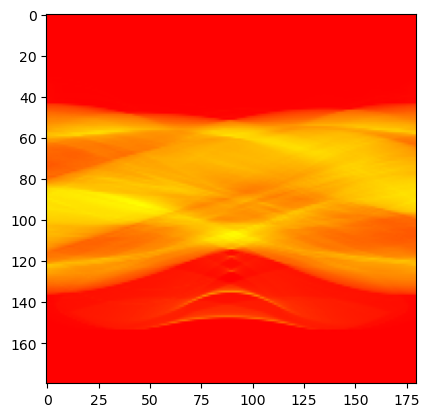

In [49]:
radon_transform = myXrayCTRadonTransform(data)

3406.9646164320447

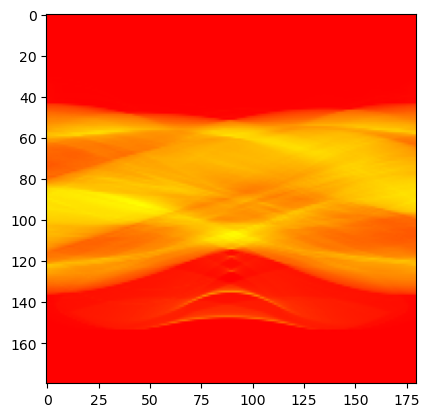

In [164]:
noisy_transform = radon_transform + np.random.normal(0, (np.max(radon_transform)+np.min(radon_transform))/40, radon_transform.shape)
plt.imshow(radon_transform, cmap='autumn')


In [162]:
print(data.shape)

def generate_A(image_shape, angles):
    h, w = image_shape
    num_pixels = h * w
    num_rays = len(angles) * w  # Each angle has w rays

    A = lil_matrix((num_pixels, num_rays))  # Each column is a ray, each row is a pixel

    dist = np.linspace(-w // 2, w // 2, w)  # Rays spaced across width
    steps = np.linspace(-max(h, w), max(h, w), 128)  # Reduced step count for efficiency

    ray_index = 0
    for theta in angles:
        cos_theta, sin_theta = np.cos(theta), np.sin(theta)  # Precompute for efficiency
        for t in dist:
            prev_pixel = (-1, -1)
            for s in steps:
                x = int(np.rint(t * cos_theta - s * sin_theta)) + w // 2
                y = int(np.rint(t * sin_theta + s * cos_theta)) + h // 2

                if 0 <= x < w and 0 <= y < h:
                    pixel_index = y * w + x
                    if (x, y) != prev_pixel:
                        A[pixel_index, ray_index] = 1
                        prev_pixel = (x, y)

            ray_index += 1  # Move to next ray

    return A.tocsr()


def myART(A, radon_transform, image_shape, num_rays):
    x = np.zeros(image_shape[0] * image_shape[1])  # Shape (262144,)

    lamda_k = 0.5
    radon_transform = radon_transform.flatten()
    for i in range(1):  # Iterations
        for j in range(num_rays):
            A_j = A[:, j].toarray().ravel()

            norm_A_j = np.linalg.norm(A_j)
            # print(norm_A_j)
            if radon_transform[j] - A_j.dot(x) > 0.1:
                print(radon_transform[j] - A_j.dot(x))
            if norm_A_j > 0:
                x += lamda_k * float(radon_transform[j] - A_j.dot(x)) / (norm_A_j ** 2)

            print(RRMSE(x, data.flatten()))

    return x



(512, 512)


In [160]:
angles = np.arange(0, np.pi, 1)
A = generate_A((512, 512), angles)

In [163]:
myART(A, radon_transform, data.shape, len(angles) * data.shape[1])

0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847614899
0.9999999847

KeyboardInterrupt: 